- http://simpy.readthedocs.io/en/latest/examples/bank_renege.html

銀行の受付の待ち状態の可視化

来客はランダムで待ち時間を設定し、それを超えると耐えきれなくなり抜ける（renaged)

サンプルに結果データを持つ変数を加えて、最後に可視化してみた。

In [17]:
"""
Bank renege example

Covers:

- Resources: Resource
- Condition events

Scenario:
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

"""
import random
import simpy

In [18]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience

In [19]:
res =[]
def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank=12.0, res=res)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

In [20]:
def customer(env, name, counter, time_in_bank, res):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    res.append({
            'time': arrive,
            'name': name,
            'status': 'arrived'
        })
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
            res.append({
                    'time': env.now,
                    'name': name,
                    'status': 'wait'
                })

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))
            res.append({
                    'time': env.now,
                    'name': name,
                    'status': 'finished'
                })

        else:
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))
            res.append({
                    'time': env.now,
                    'name': name,
                    'status': 'reneged'
                })


In [21]:
# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 3.8595 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
23.7507 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
37.9599 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
43.1401 Customer04: Finished


In [22]:
import pandas as pd
res_df = pd.DataFrame(res)
res_df.head()

,name,status,time
0,Customer00,arrived,0.000000
1,Customer00,wait,0.000000
2,Customer00,finished,3.859489
3,Customer01,arrived,10.200603
4,Customer01,wait,10.200603


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

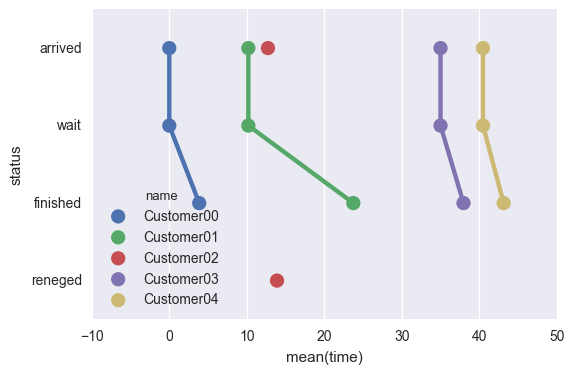

In [24]:
sns.pointplot(data=res_df, x="time" , y="status", hue="name")